# Import Libraries

In [ ]:
# !pip install kaggle
# !kaggle datasets list

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'DeepLearningGroup8!'
os.environ['KAGGLE_KEY'] = 'DeepLearningGroup8'

In [ ]:
# Install packages if needed with this command:
#!pip install -r requirements.txt
# !pip install kaggle
import os
import kaggle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# From here, add any libraries that you might need for the rest of your code
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import keras as kt
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , ELU, LeakyReLU, Dropout, Lambda, BatchNormalization
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import numpy as np
import keras_tuner as kt


# 1. Load dataset


In [ ]:
# download data second way with kaggel user name - password
data_dir = 'driver-inattention-detection-dataset'
if not os.path.isdir(data_dir):
    kaggle.api.dataset_download_files('zeyad1mashhour/driver-inattention-detection-dataset',
                                    path=data_dir, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/zeyad1mashhour/driver-inattention-detection-dataset


In [ ]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# read the file containing the class labels
with open(os.path.join(data_dir, 'train', '_classes.txt')) as f:
    classes = list(map(str.strip, f))

# read image paths and labels and store them in pandas dataframes
with open(os.path.join(data_dir, 'test', '_annotations.txt'), 'r') as f:
    df_test = pd.DataFrame(dict(img=os.path.join(data_dir, 'test', line.split()[0]),
                                label=classes[int(line.strip()[-1])]) for line in f)

with open(os.path.join(data_dir, 'valid', '_annotations.txt'), 'r') as f:
    df_val = pd.DataFrame(dict(img=os.path.join(data_dir, 'valid', line.split()[0]),
                               label=classes[int(line.strip()[-1])]) for line in f)

with open(os.path.join(data_dir, 'train', '_annotations.txt'), 'r') as f:
    df_train = pd.DataFrame(dict(img=os.path.join(data_dir, 'train', line.split()[0]),
                                 label=classes[int(line.strip()[-1])]) for line in f if len(line.split())>1)

# pre-processing parameters
image_unit_res = 8
img_height, img_width = 9*image_unit_res, 16*image_unit_res # 16:9 preserve aspect ratio
batch_size = 32

def add_noise(img):
    std_coeff = 50*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

train_data = data_gen.flow_from_dataframe(
    df_train, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale')

val_data = data_gen.flow_from_dataframe(
    df_val, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

test_data = data_gen.flow_from_dataframe(
    df_test, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')


Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


# 2. Visualise data and plot data distribution

## 2.1. Step 1: Convert Target Values to One-Hot Encoding

In [ ]:
train_data

In [ ]:
# Get class indices from the generator
class_indices = train_data.class_indices
num_classes = len(class_indices)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(train_data.labels, num_classes=num_classes)
y_val_one_hot = to_categorical(val_data.labels, num_classes=num_classes)
y_test_one_hot = to_categorical(test_data.labels, num_classes=num_classes)

In [ ]:
y_train_one_hot

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

## 2.2. Step 2: Randomly Select 15 Samples and Display with Labels

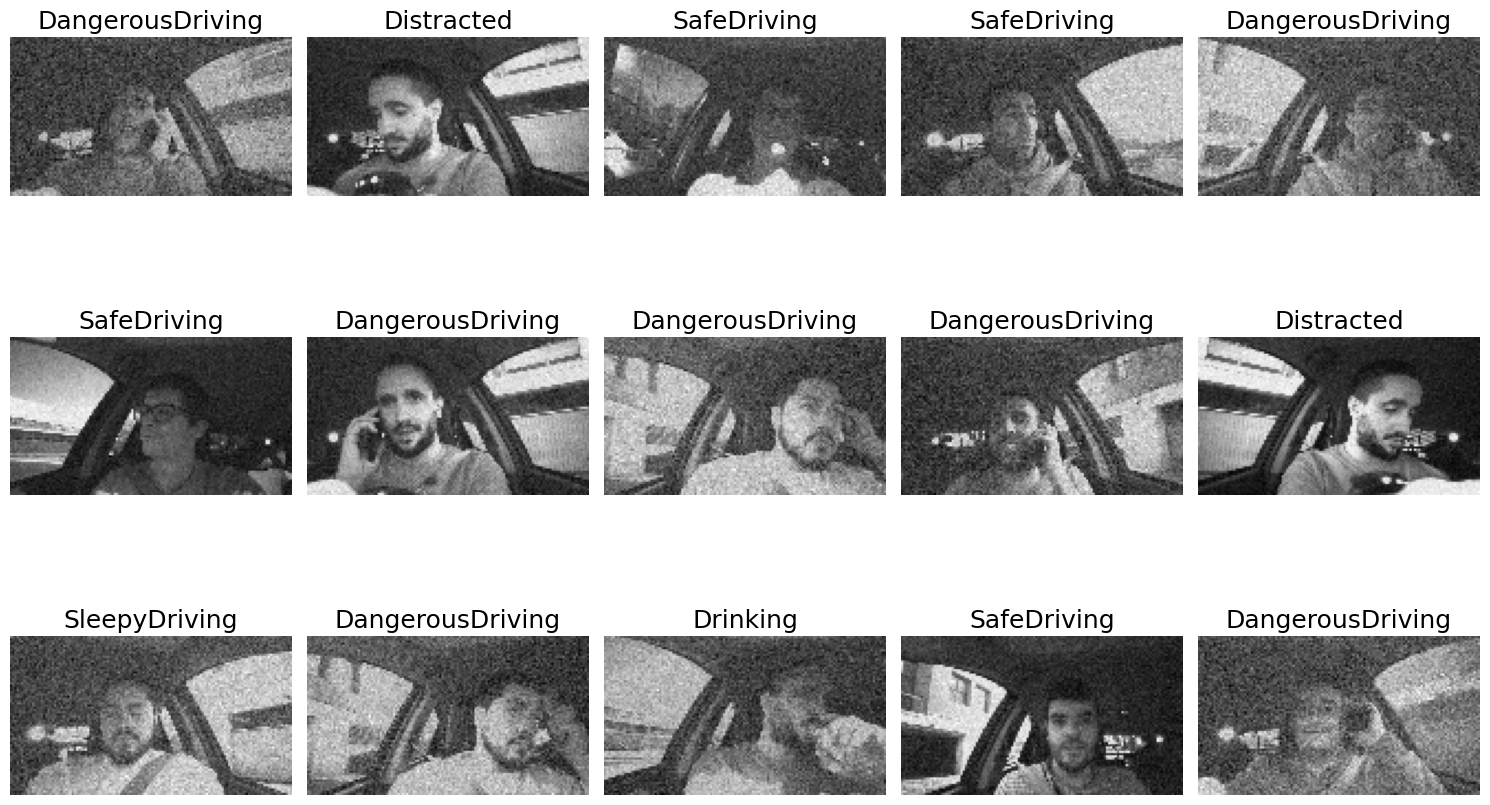

In [ ]:
import random
from tensorflow.keras.preprocessing.image import load_img
# Select 15 random indices from train_data
random_indices = random.sample(range(len(train_data)), 15)

# Initialize a list to store the random images and their labels
random_images = []
random_labels = []

# Loop through the random indices to get images and labels from train_data
for i in random_indices:
    # Get the current image and label from train_data
    img, label = train_data[i]  # img is the batch of images, label is the corresponding batch of labels

    # We need to extract the image and label corresponding to the i-th random index in the batch
    random_images.append(img[0])  # First image in the batch (index 0)

    # Find the index of the class
    class_index = np.argmax(label[0])

    # convert the class index to its name
    class_name = list(train_data.class_indices.keys())[list(train_data.class_indices.values()).index(class_index)]

    # Append class name to random_labels list
    random_labels.append(class_name)

# Plot these 15 random images
plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(random_images[i].reshape(img_height, img_width), cmap='gray')  # Convert to grayscale image and reshape
    plt.title(random_labels[i], fontsize=18)  # Set label as title
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

## 2.3. Step 3: Create a Bar Plot to Show Class Distribution

In [ ]:
print(train_data.class_indices)

{'DangerousDriving': 0, 'Distracted': 1, 'Drinking': 2, 'SafeDriving': 3, 'SleepyDriving': 4, 'Yawn': 5}


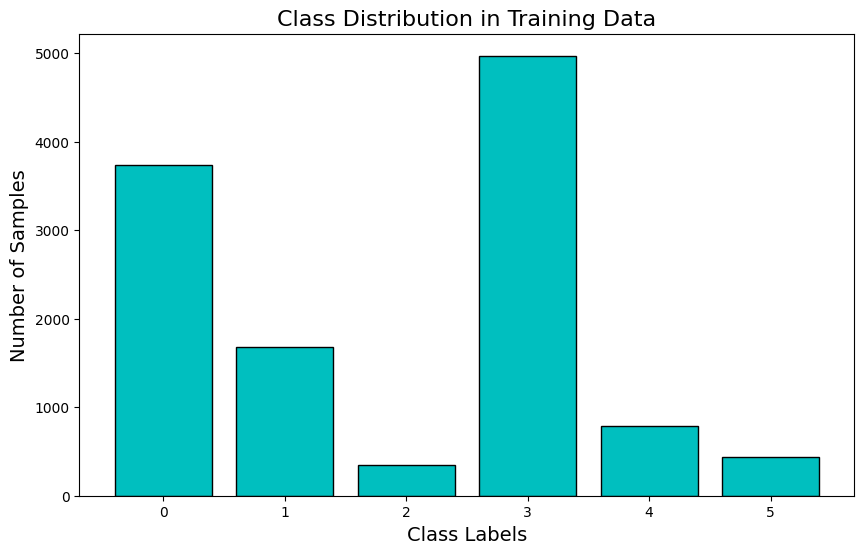

In [ ]:
# Count occurrences of each class in the training dataset
class_counts = pd.Series(train_data.labels).value_counts()

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, color='c', edgecolor='black')
plt.xlabel("Class Labels", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.title("Class Distribution in Training Data", fontsize=16)
plt.show()

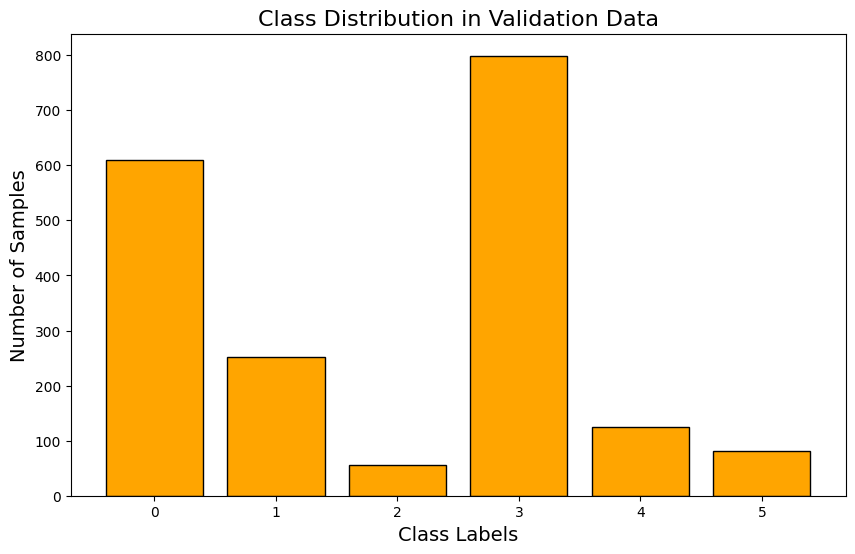

In [ ]:
# Count occurrences of each class in the validation dataset
class_counts_val = pd.Series(val_data.labels).value_counts()

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_counts_val.index, class_counts_val.values, color='orange', edgecolor='black')
plt.xlabel("Class Labels", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.title("Class Distribution in Validation Data", fontsize=16)
plt.show()

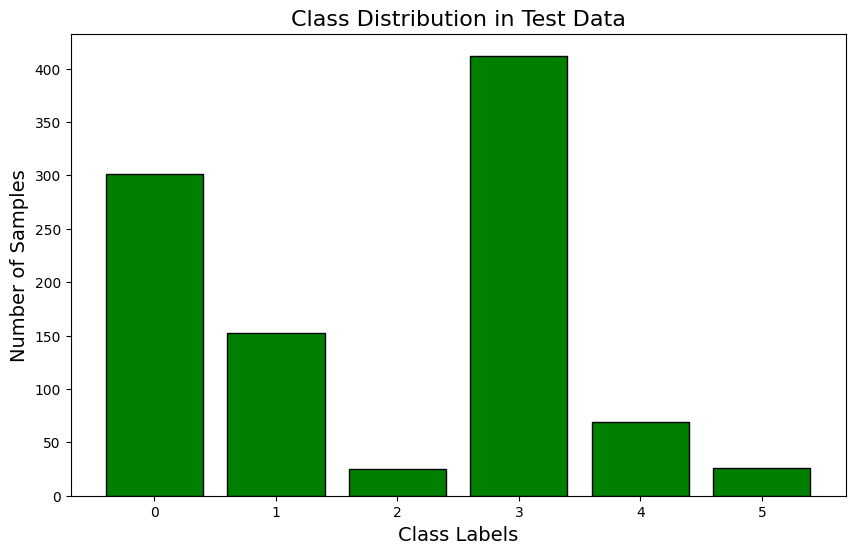

In [ ]:
# Count occurrences of each class in the test dataset
class_counts_test = pd.Series(test_data.labels).value_counts()

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_counts_test.index, class_counts_test.values, color='g', edgecolor='black')
plt.xlabel("Class Labels", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.title("Class Distribution in Test Data", fontsize=16)
plt.show()

## 2.4. Step 4: Data Augmentation

In [ ]:
class_counts = pd.Series(train_data.labels).value_counts()
class_counts

,count
3,4969
0,3732
1,1676
4,785
5,439
2,347


In [ ]:
# Get class index mapping
class_indices = {v: k for k, v in train_data.class_indices.items()}  # Reverse the dictionary

# Count occurrences of each class in the training dataset
class_counts = pd.Series(train_data.labels).value_counts()

# Map indices to class names
class_counts.index = class_counts.index.map(class_indices)

class_counts

,count
SafeDriving,4969
DangerousDriving,3732
Distracted,1676
SleepyDriving,785
Yawn,439
Drinking,347


In [ ]:
# Data augmentation for underrespresented classes

# Distribution and target count
current_distribution = {
    'SafeDriving': 4969,
    'DangerousDriving': 3732,
    'Distracted': 1676,
    'SleepyDriving': 785,
    'Yawn': 439,
    'Drinking': 347
}
target = 4969
augment_classes = ['DangerousDriving', 'Distracted', 'SleepyDriving', 'Yawn', 'Drinking']

# Set up a new ImageDataGenerator for augmentation
augment_datagen = ImageDataGenerator(
    rotation_range=30,           # Rotate the image
    width_shift_range=0.1,       # Horizontally shift the image
    height_shift_range=0.2,      # Vertically shift the image
    zoom_range=0.3,              # Zoom in on the image
    brightness_range=[0.7, 1.3], # Adjust the brightness
    horizontal_flip=True,        # Horizontally flip the image
)

# Directory to save augmented images
output_dir = 'augmented_images'
os.makedirs(output_dir, exist_ok=True)

augmented_samples = []

for cls in augment_classes:
    num_to_generate = target - current_distribution[cls]
    print(f"Augmenting '{cls}': need {num_to_generate} additional samples.")

    cls_df = df_train[df_train['label'] == cls]
    cls_images = cls_df['img'].tolist()

    # Convert relative paths to absolute paths
    cls_images = [os.path.abspath(img) for img in cls_images]
    print(f"Found {len(cls_images)} images for class {cls}.")

    if not cls_images:
        print(f"No images found for class '{cls}'. Skipping augmentation.")
        continue

    generated = 0
    # To prevent infinite loops, track if a full pass produced at least one augmentation.
    pass_success = False
    while generated < num_to_generate:
        for img_path in cls_images:
            if generated >= num_to_generate:
                break
            try:
                # Load the image with the target size
                img = load_img(img_path, target_size=(img_height, img_width))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)

                # Generate one augmented image
                aug_iter = augment_datagen.flow(x, batch_size=1)
                aug_img = next(aug_iter)[0].astype('uint8')

                # Save augmented image
                aug_filename = f"{cls}_aug_{generated}.jpg"
                save_path = os.path.join(output_dir, aug_filename)
                array_to_img(aug_img).save(save_path)

                # Record augmented sample info
                augmented_samples.append({"img": save_path, "label": cls})
                generated += 1
                pass_success = True
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
        if not pass_success:
            print(f"Unable to generate any augmented images for class '{cls}'.")
            break
        pass_success = False
    print(f"Finished augmenting '{cls}'. Generated {generated} images.\n")

# Create a DataFrame from the augmented sample info.
augmented_df = pd.DataFrame(augmented_samples, columns=["img", "label"])
if augmented_df.empty:
    print("No augmented images were generated. Please check your file paths and settings.")
else:
    # Create an augmented data generator from the newly augmented images.
    augmented_train_data = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        augmented_df, x_col='img', y_col='label',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale'
    )
    print("Augmented data generator (augmented_train_data) is ready.")

# Combine the original training dataframe with the augmented samples
augmented_df = pd.concat([df_train, augmented_df], ignore_index=True)

# Create a new training generator using the original ImageDataGenerator
augmented_train_data = data_gen.flow_from_dataframe(
    augmented_df,
    x_col='img',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

Augmenting 'DangerousDriving': need 1237 additional samples.
Found 3732 images for class DangerousDriving.
Finished augmenting 'DangerousDriving'. Generated 1237 images.

Augmenting 'Distracted': need 3293 additional samples.
Found 1676 images for class Distracted.
Finished augmenting 'Distracted'. Generated 3293 images.

Augmenting 'SleepyDriving': need 4184 additional samples.
Found 785 images for class SleepyDriving.
Finished augmenting 'SleepyDriving'. Generated 4184 images.

Augmenting 'Yawn': need 4530 additional samples.
Found 439 images for class Yawn.
Finished augmenting 'Yawn'. Generated 4530 images.

Augmenting 'Drinking': need 4622 additional samples.
Found 347 images for class Drinking.
Finished augmenting 'Drinking'. Generated 4622 images.

Found 17866 validated image filenames belonging to 5 classes.
Augmented data generator (augmented_train_data) is ready.
Found 29814 validated image filenames belonging to 6 classes.


In [ ]:
augmented_train_data.class_indices

{'DangerousDriving': 0,
 'Distracted': 1,
 'Drinking': 2,
 'SafeDriving': 3,
 'SleepyDriving': 4,
 'Yawn': 5}

In [ ]:
y_train_one_hot = to_categorical(augmented_train_data.labels, num_classes=num_classes)
y_train_one_hot

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

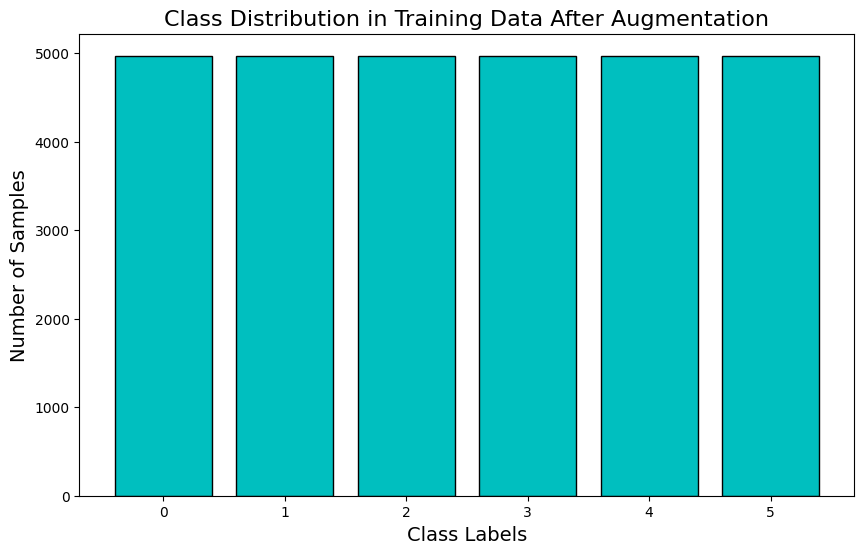

In [ ]:
# Count occurrences of each class in the training dataset after augmentation
class_counts = pd.Series(augmented_train_data.labels).value_counts()

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, color='c', edgecolor='black')
plt.xlabel("Class Labels", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)
plt.title("Class Distribution in Training Data After Augmentation", fontsize=16)
plt.show()

## 2.5. Step 5: Make functions for Model Evaluation & Plots

In [ ]:
def evaluation_model(model, history, title='Baseline', val_data=val_data, test_data=test_data,
                     class_labels=['DangerousDriving', 'Distracted', 'Drinking', 'SafeDriving', 'SleepyDriving', 'Yawn'],
                     function_to_run=None):
    """
    Parameters:
    Change these to your model and name it:
      model: The compiled model.
      history: The history object returned from model.fit().
      title (str): A title prefix for the plots. Defaults to 'Baseline'.

    Do not touch these:
      val_data: The validation data.
      test_data: The test data.
      class_labels: The list of class names.
    """

    # 1. Plot Training Curves
    def plot_training_curves(history, title):
        """Plot training and validation loss and accuracy curves."""
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        plt.figure(figsize=(12, 5))
        # Loss subplot
        plt.subplot(1, 2, 1)
        plt.plot(train_loss, label='Training Loss', marker='o')
        plt.plot(val_loss, label='Validation Loss', marker='s')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'{title}: Training vs Validation Loss')
        plt.legend()
        plt.grid(True, alpha=0.6)

        # Accuracy subplot
        plt.subplot(1, 2, 2)
        plt.plot(train_acc, label='Training Accuracy', marker='o')
        plt.plot(val_acc, label='Validation Accuracy', marker='s')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'{title}: Training vs Validation Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.6)

        plt.tight_layout()
        plt.show()

    # 2. Plot ROC Curve
    def plot_roc_curve(y_true, y_pred_probs, class_labels, title):
        """Plot ROC curves for each class."""
        from sklearn.metrics import roc_curve, auc

        plt.figure(figsize=(8, 5))
        for i, label in enumerate(class_labels):
            fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {i} ({label}) AUC={roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{title}: ROC Curve')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # 3. Plot Confusion Matrix
    def plot_confusion_matrix_func(ax, y_true_indices, y_pred, class_labels, title):
        """Plot a confusion matrix."""
        from sklearn.metrics import confusion_matrix

        cm = confusion_matrix(y_true_indices, y_pred)
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(title)
        ax.set_xticks(np.arange(len(class_labels)))
        ax.set_yticks(np.arange(len(class_labels)))
        ax.set_xticklabels(class_labels, rotation=45, ha='right')
        ax.set_yticklabels(class_labels)

        for i in range(len(class_labels)):
            for j in range(len(class_labels)):
                ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        plt.colorbar(im, ax=ax)
        plt.tight_layout()

    # 4. Plot Classification Metrics
    def plot_classification_metrics(y_val_true, y_val_pred, y_test_true, y_test_pred, class_labels):
        """Plot classification metrics per class."""
        val_report = classification_report(y_val_true, y_val_pred, target_names=class_labels, output_dict=True)
        test_report = classification_report(y_test_true, y_test_pred, target_names=class_labels, output_dict=True)

        val_df = pd.DataFrame(val_report).T.iloc[:-3, :-1]
        test_df = pd.DataFrame(test_report).T.iloc[:-3, :-1]

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        for metric in ['precision', 'recall', 'f1-score']:
            plt.plot(class_labels, val_df[metric], marker='o', label=metric)
        plt.xlabel(f'Validation Accuracy: {np.round(val_report["accuracy"], 2)}')
        plt.ylabel('Score')
        plt.title(f'{title}: Validation Metrics per Class')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.6)

        plt.subplot(1, 2, 2)
        for metric in ['precision', 'recall', 'f1-score']:
            plt.plot(class_labels, test_df[metric], marker='o', label=metric)
        plt.xlabel(f'Test Accuracy: {np.round(test_report["accuracy"], 2)}')
        plt.ylabel('Score')
        plt.title(f'{title}: Test Metrics per Class')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.6)

        plt.tight_layout()
        plt.show()

    # 5. Generate Classification Report Summary
    def classification_report_summary(y_val_true, y_val_pred, y_test_true, y_test_pred, class_labels):
        """Print a detailed classification report."""
        val_report = classification_report(y_val_true, y_val_pred, target_names=class_labels, output_dict=True)
        test_report = classification_report(y_test_true, y_test_pred, target_names=class_labels, output_dict=True)

        val_df = pd.DataFrame(val_report).T.iloc[:-3, :-1]
        test_df = pd.DataFrame(test_report).T.iloc[:-3, :-1]

        print(f"\n{title} - Classification Report:")
        print("\nValidation Performance Metrics:\n", val_df.to_string())
        print("\nValidation Accuracy:", val_report['accuracy'])
        print("\nTest Performance Metrics:\n", test_df.to_string())
        print("\nTest Accuracy:", test_report['accuracy'])

    # --- Retrieve True Labels and Predictions ---
    y_val_true = val_data.labels
    y_test_true = test_data.labels

    y_val_true_onehot = tf.keras.utils.to_categorical(y_val_true, num_classes=len(class_labels))
    y_test_true_onehot = tf.keras.utils.to_categorical(y_test_true, num_classes=len(class_labels))

    y_val_pred_probs = model.predict(val_data)
    y_test_pred_probs = model.predict(test_data)

    y_val_pred = np.argmax(y_val_pred_probs, axis=1)
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)

    # --- Call Specific Function if Specified ---
    if function_to_run == "plot_training_curves":
        plot_training_curves(history, title)
        return
    elif function_to_run == "plot_roc_curve":
        plot_roc_curve(y_val_true_onehot, y_val_pred_probs, class_labels, title)
        return
    elif function_to_run == "plot_confusion_matrix":
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        plot_confusion_matrix_func(axes[0], y_val_true, y_val_pred, class_labels, f'{title}: Confusion Matrix - Validation')
        plot_confusion_matrix_func(axes[1], y_test_true, y_test_pred, class_labels, f'{title}: Confusion Matrix - Test')
        plt.tight_layout()
        plt.show()
        return
    elif function_to_run == "plot_classification_metrics":
        plot_classification_metrics(y_val_true, y_val_pred, y_test_true, y_test_pred, class_labels)
        return
    elif function_to_run == "classification_report_summary":
        classification_report_summary(y_val_true, y_val_pred, y_test_true, y_test_pred, class_labels)
        return

    # --- Default: Run All Functions ---
    plot_training_curves(history, title)
    plot_roc_curve(y_val_true_onehot, y_val_pred_probs, class_labels, title)
    plot_confusion_matrix_func(ax=ax, y_true_indices=y_true_indices, y_pred=y_pred, class_labels=class_labels, title=title)
    plot_classification_metrics(y_val_true, y_val_pred, y_test_true, y_test_pred, class_labels)
    classification_report_summary(y_val_true, y_val_pred, y_test_true, y_test_pred, class_labels)

# 3. Train and Evaluation functions

## 3.1. Baseline CNN Implementation

In [ ]:
#Define image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 72, 128, 1
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
BATCH_SIZE = 32

#Define kernel and pooling sizes as variables
KERNEL_SIZE = (3, 3)
POOL_SIZE = (2, 2)

#Initialize sequential model
model = Sequential()

#Add layer one
model.add(layers.Conv2D(8, KERNEL_SIZE, activation='relu', input_shape=INPUT_SHAPE))  #Conv layer
model.add(layers.MaxPooling2D(pool_size=POOL_SIZE))  #Pooling layer

#Add layer two
model.add(layers.Conv2D(8, KERNEL_SIZE, activation='relu'))  #Conv layer
model.add(layers.MaxPooling2D(pool_size=POOL_SIZE))  #Pooling layer

#Add layer three
model.add(layers.Conv2D(8, KERNEL_SIZE, activation='relu'))  #Conv layer
model.add(layers.MaxPooling2D(pool_size=POOL_SIZE))  #Pooling layer

#Flatten the output to feed it into dense layers
model.add(layers.Flatten())

#Fully Connected Layer 2: Dense layer with 10 units
model.add(layers.Dense(10, activation='relu'))

#Output Layer: Dense layer with 6 units for classification
model.add(layers.Dense(6, activation='softmax'))  #Output layer with 6 logits

#Print model summary
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           7,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,164 (35.80 KB)

 Trainable params: 9,164 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),  #Chosen loss function for multi-class classification
    metrics=['accuracy']
)

In [ ]:
#Train the model
history = model.fit(
    augmented_train_data,  #Training dataset
    epochs=10,
    validation_data=val_data,
    batch_size=BATCH_SIZE
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


932/932 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.2646 - loss: 1.6671 - val_accuracy: 0.5619 - val_loss: 1.1263
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4578 - loss: 1.2718 - val_accuracy: 0.6327 - val_loss: 0.9836
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5035 - loss: 1.1677 - val_accuracy: 0.6727 - val_loss: 0.9238
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5208 - loss: 1.1140 - val_accuracy: 0.7003 - val_loss: 0.8343
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5629 - loss: 1.0319 - val_accuracy: 0.7201 - val_loss: 0.8233
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.5861 - loss: 0.9905 - val_accuracy: 0.7060 - val_loss: 0.7834
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5930 - loss: 0.9619 - val_accuracy: 0.7466 - val_loss: 0.7381
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.6017 - loss: 0.9344 - val_accurac

##3.2. Performance Evaluation of the Baseline Model
### 3.2.1. Plot Training & Validation Loss/Accuracy Curves

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


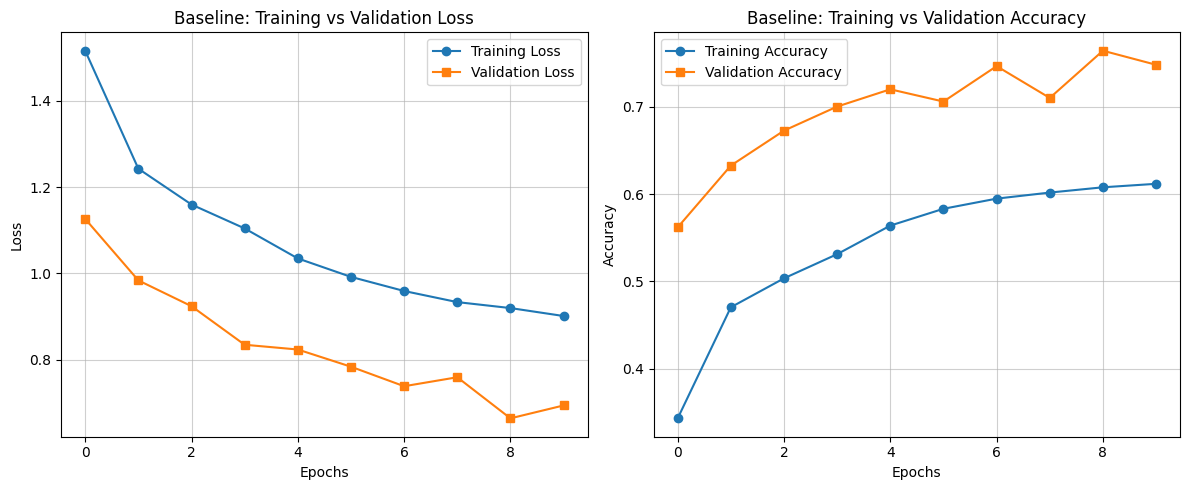

In [ ]:
evaluation_model(model, history, title='Baseline', function_to_run='plot_training_curves')

### 3.2.2. Compute & Plot the ROC with AUC Score

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


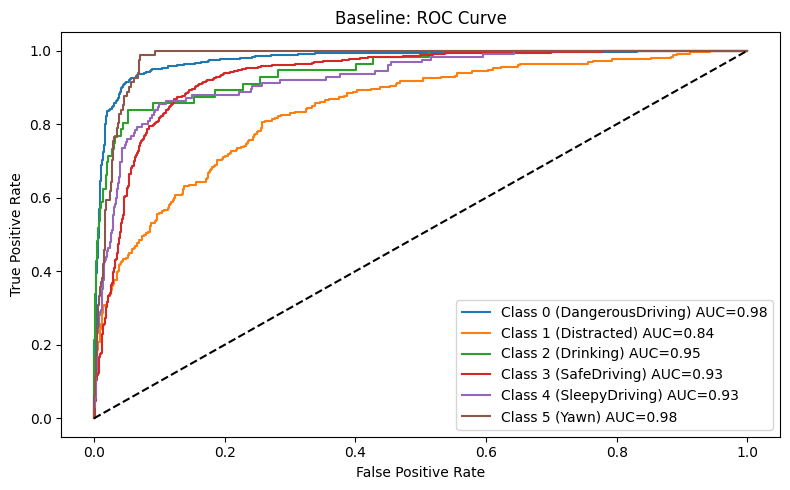

In [ ]:
evaluation_model(model, history, title='Baseline', function_to_run='plot_roc_curve')

### 3.2.3. Compute & Plot Confusion Matrix

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


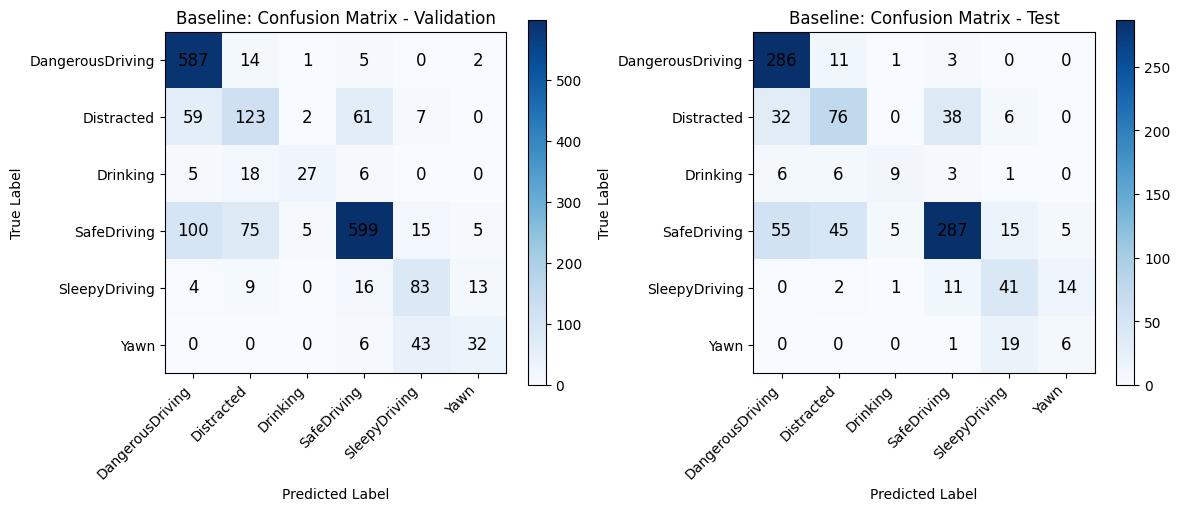

In [ ]:
evaluation_model(model, history, title='Baseline', function_to_run='plot_confusion_matrix')

### 3.2.4. Plot Classification Metrics

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


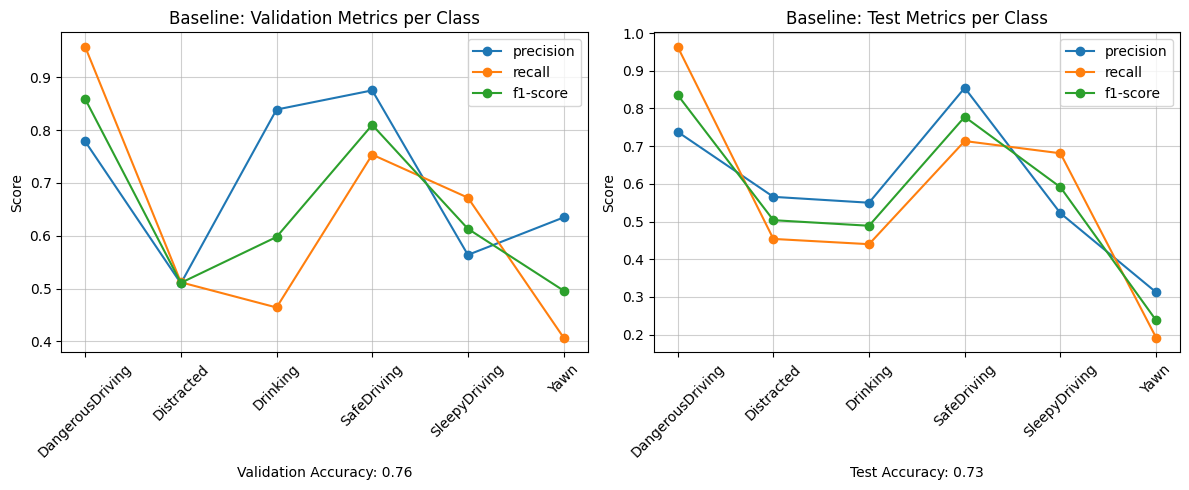

In [ ]:
evaluation_model(model, history, title='Baseline', function_to_run='plot_classification_metrics')

### 3.2.5. Compute Performance Metrics (Accuracy, Precision, Recall, F1-Score)

In [ ]:
evaluation_model(model, history, title='Baseline', function_to_run='classification_report_summary')

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step

Baseline - Classification Report:

Validation Performance Metrics:
                   precision    recall  f1-score
DangerousDriving   0.775000  0.967159  0.860482
Distracted         0.524793  0.503968  0.514170
Drinking           0.821429  0.410714  0.547619
SafeDriving        0.870827  0.750939  0.806452
SleepyDriving      0.545455  0.672000  0.602151
Yawn               0.591837  0.358025  0.446154

Validation Accuracy: 0.7554630593132154

Test Performance Metrics:
                   precision    recall  f1-score
DangerousDriving   0.735219  0.950166  0.828986
Distracted         0.549618  0.473684  0.508834
Drinking           0.571429  0.320000  0.410256
SafeDriving        0.848837  0.708738  0.772487
SleepyDriving      0.494382  0.637681  0.556962
Yawn               0.333333  0.230769  0.272727

Test Accuracy: 0.7187817258883249


#3.3. Model Improvement & Hyperparameter Tuning

In [ ]:
#Define image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 72, 128, 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
batch_size = 32


# IMPROVED MODEL 1
Addition of more layers : New Block 4 added
* NOTE : did not improve baseline

In [ ]:
# Build the updated model with more layers
model_more_layer = Sequential([
    # Block 1
    Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),

    # Block 2
    Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Block 3
    Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # New Block 4: Additional Layer
    Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten the output to create a feature vector
    Flatten(),

    # Dense layer projecting to 10 dimensions, followed by ReLU
    Dense(10, activation='relu'),

    # Final dense layer projecting to 6 logits (one for each class)
    Dense(6, activation='softmax')
])

# Print the model summary
model_more_layer.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 5, 12, 8)            │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 2, 6, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             970 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,868 (11.20 KB)

 Trainable params: 2,868 (11.20 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_more_layer.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_more_layer = model_more_layer.fit(
    augmented_train_data,
    epochs=10,
    validation_data=val_data,
    batch_size=batch_size
)



Epoch 1/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.2702 - loss: 1.6366 - val_accuracy: 0.5630 - val_loss: 1.1531
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.4450 - loss: 1.3214 - val_accuracy: 0.6217 - val_loss: 1.0339
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 52s 56ms/step - accuracy: 0.4855 - loss: 1.2291 - val_accuracy: 0.6738 - val_loss: 0.9111
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 92s 66ms/step - accuracy: 0.5129 - loss: 1.1598 - val_accuracy: 0.6925 - val_loss: 0.8688
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.5423 - loss: 1.1088 - val_accuracy: 0.7066 - val_loss: 0.8348
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - accuracy: 0.5496 - loss: 1.0730 - val_accuracy: 0.7206 - val_loss: 0.8104
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 53s 56ms/step - accuracy: 0.5627 - loss: 1.0462 - val_accuracy: 0.7253 - val_loss: 0.7739
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 54s 58ms/step - accuracy: 0.5721 - loss: 1.0149 - 

In [ ]:
test_loss, test_acc = model_more_layer.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7175 - loss: 0.7633
Test Loss: 0.7636900544166565
Test Accuracy: 0.7187817096710205


# IMPROVED MODEL 2
Alterations in filter sizes and numbers ( no additional 4.block )
* NOTE : improved baseline

In [ ]:
# Build the updated model with altered filter sizes and numbers
model_different_filter_size = Sequential([
    # Block 1
    # Increase filters from 8 to 16 and use a larger kernel size (5x5)
    Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),

    # Block 2
    # Increase filters from 8 to 32 with standard 3x3 kernel
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Block 3
    # Increase filters from 8 to 64 with standard 3x3 kernel
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten the output into a feature vector
    Flatten(),

    # Dense layer projecting the feature vector to 10 dimensions, followed by ReLU
    Dense(10, activation='relu'),

    # Final dense layer projecting the 10-dimensional vector to 6 logits (one for each class)
    Dense(6, activation='softmax')
])

# Print the model summary
model_different_filter_size.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 68, 124, 16)         │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 34, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 60, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 14, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │          62,730 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,348 (337.30 KB)

 Trainable params: 86,348 (337.30 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_different_filter_size.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_different_filter_size = model_different_filter_size.fit(
    augmented_train_data,
    epochs=10,
    validation_data=val_data,
    batch_size=batch_size
)


Epoch 1/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 51s 52ms/step - accuracy: 0.2418 - loss: 1.7314 - val_accuracy: 0.4350 - val_loss: 1.5356
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 50s 54ms/step - accuracy: 0.3246 - loss: 1.5213 - val_accuracy: 0.4932 - val_loss: 1.3762
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.3833 - loss: 1.3940 - val_accuracy: 0.6493 - val_loss: 1.1379
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.5233 - loss: 1.1351 - val_accuracy: 0.6982 - val_loss: 0.9646
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.5755 - loss: 1.0024 - val_accuracy: 0.7357 - val_loss: 0.8258
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.6102 - loss: 0.9168 - val_accuracy: 0.7555 - val_loss: 0.7715
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - accuracy: 0.6316 - loss: 0.8610 - val_accuracy: 0.7846 - val_loss: 0.7077
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 49s 52ms/step - accuracy: 0.6469 - loss: 0.8261 - 

In [ ]:
test_loss, test_acc = model_different_filter_size.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.7559 - loss: 0.7419
Test Loss: 0.6964980363845825
Test Accuracy: 0.7705583572387695


# IMPROVED MODEL 3
Adjustments to activation functions: LeakyReLU
* NOTE: improved baseline

In [ ]:
# Build the model with LeakyReLU activation function
model_LeakyReLU = Sequential([
    # Block 1
    Conv2D(filters=8, kernel_size=(3,3), input_shape=input_shape),  # No activation here
    LeakyReLU(alpha=0.1),  # Apply LeakyReLU after the convolution
    MaxPooling2D(pool_size=(2,2)),

    # Block 2
    Conv2D(filters=8, kernel_size=(3,3)),  # No activation here
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2,2)),

    # Block 3
    Conv2D(filters=8, kernel_size=(3,3)),  # No activation here
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten the output
    Flatten(),

    # Dense layer projecting the flattened vector to 10 dimensions
    Dense(10),  # No activation here
    LeakyReLU(alpha=0.1),

    # Final dense layer projecting to 6 logits (one for each class) with softmax for probabilities
    Dense(6, activation='softmax')
])

# Print the model summary
model_LeakyReLU.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 70, 126, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 33, 61, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 28, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │           7,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,164 (35.80 KB)

 Trainable params: 9,164 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_LeakyReLU.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_LeakyReLU = model_LeakyReLU.fit(
    augmented_train_data,
    epochs=10,
    validation_data=val_data
)


Epoch 1/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 53s 54ms/step - accuracy: 0.3612 - loss: 1.5075 - val_accuracy: 0.6915 - val_loss: 0.8316
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 79s 52ms/step - accuracy: 0.5447 - loss: 1.1090 - val_accuracy: 0.7758 - val_loss: 0.6872
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.5969 - loss: 1.0035 - val_accuracy: 0.7820 - val_loss: 0.6281
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - accuracy: 0.6151 - loss: 0.9406 - val_accuracy: 0.7976 - val_loss: 0.6004
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.6392 - loss: 0.8879 - val_accuracy: 0.7659 - val_loss: 0.6308
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.6496 - loss: 0.8605 - val_accuracy: 0.8247 - val_loss: 0.5515
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 48s 52ms/step - accuracy: 0.6606 - loss: 0.8289 - val_accuracy: 0.7877 - val_loss: 0.6331
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.6684 - loss: 0.8185 - 

In [ ]:
test_loss, test_acc = model_LeakyReLU.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.8086 - loss: 0.5650
Test Loss: 0.5440325140953064
Test Accuracy: 0.817258894443512


# IMPROVED MODEL 4
Adjustments to activation functions : ELU
* NOTE : it improved baseline

In [ ]:
# Build the model with ELU activation function
model_ELU = Sequential([
    # Block 1
    Conv2D(filters=8, kernel_size=(3,3), input_shape=input_shape),  # No activation here
    ELU(alpha=1.0),  # Apply ELU activation after the convolution
    MaxPooling2D(pool_size=(2,2)),

    # Block 2
    Conv2D(filters=8, kernel_size=(3,3)),  # No activation here
    ELU(alpha=1.0),
    MaxPooling2D(pool_size=(2,2)),

    # Block 3
    Conv2D(filters=8, kernel_size=(3,3)),  # No activation here
    ELU(alpha=1.0),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten the output into a feature vector
    Flatten(),

    # Dense layer projecting the flattened vector to 10 dimensions
    Dense(10),  # No activation here
    ELU(alpha=1.0),

    # Final dense layer projecting the 10-dimensional vector to 6 logits (one for each class)
    Dense(6, activation='softmax')
])

# Print the model summary
model_ELU.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 70, 126, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_1 (ELU)                          │ (None, 33, 61, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_2 (ELU)                          │ (None, 14, 28, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           7,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_3 (ELU)                          │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,164 (35.80 KB)

 Trainable params: 9,164 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_ELU.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_ELU = model_ELU.fit(
    augmented_train_data,
    epochs=10,
    validation_data=val_data,
    batch_size=batch_size
)


Epoch 1/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.3813 - loss: 1.4884 - val_accuracy: 0.7050 - val_loss: 0.8495
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.5422 - loss: 1.1235 - val_accuracy: 0.7378 - val_loss: 0.7392
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.5882 - loss: 1.0133 - val_accuracy: 0.7643 - val_loss: 0.6629
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.6114 - loss: 0.9494 - val_accuracy: 0.7851 - val_loss: 0.6154
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.6291 - loss: 0.8922 - val_accuracy: 0.7945 - val_loss: 0.5961
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.6404 - loss: 0.8709 - val_accuracy: 0.7976 - val_loss: 0.5709
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.6486 - loss: 0.8421 - val_accuracy: 0.8195 - val_loss: 0.5353
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.6601 - loss: 0.8073 - 

In [ ]:
test_loss, test_acc = model_ELU.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8129 - loss: 0.5664
Test Loss: 0.5660182237625122
Test Accuracy: 0.8121827244758606


# IMPROVED MODEL 5
Fine-tuning the learning rate together with different optimizers: Adamax
* NOTE : it did not improve baseline

In [ ]:


# Build the model with Adamax optimizer
model_Adamax = Sequential([
    # Block 1
    Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),

    # Block 2
    Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Block 3
    Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten the output to create a 784-dimensional vector
    Flatten(),

    # Dense layer projecting the 784-dimensional vector to 10 dimensions, followed by ReLU
    Dense(10, activation='relu'),

    # Final dense layer projecting the 10-dimensional vector to 6 logits (one for each class)
    Dense(6, activation='softmax')
])

# Print the model summary
model_Adamax.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │           7,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,164 (35.80 KB)

 Trainable params: 9,164 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Set a base learning rate for fine-tuning
learning_rate = 0.0001



optimizer_adamax = Adamax(learning_rate=learning_rate)

# Compile the model with Adamax optimizer
model_Adamax.compile(optimizer=optimizer_adamax,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history_Adamax = model_Adamax.fit(
    augmented_train_data,
    epochs=10,
    validation_data=val_data,
    batch_size=batch_size
)

Epoch 1/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 48s 49ms/step - accuracy: 0.1823 - loss: 1.7896 - val_accuracy: 0.4178 - val_loss: 1.7184
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.3123 - loss: 1.7221 - val_accuracy: 0.4407 - val_loss: 1.5621
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - accuracy: 0.3518 - loss: 1.5942 - val_accuracy: 0.4781 - val_loss: 1.4101
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.3820 - loss: 1.5024 - val_accuracy: 0.5255 - val_loss: 1.3323
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.4058 - loss: 1.4570 - val_accuracy: 0.5479 - val_loss: 1.2889
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.4087 - loss: 1.4261 - val_accuracy: 0.5578 - val_loss: 1.2435
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.4242 - loss: 1.3998 - val_accuracy: 0.5775 - val_loss: 1.2076
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.4315 - loss: 1.3710 - 

In [ ]:
test_loss, test_acc = model_Adamax.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5853 - loss: 1.1443
Test Loss: 1.160422444343567
Test Accuracy: 0.5786802172660828


# IMPROVED MODEL 6
Fine-tuning the learning rate together with different optimizers: RMSProp.
* NOTE : it did not improve baseline

In [ ]:
# Build the model with RMSProp optimizer
model_RMSProp = Sequential([
    # Block 1
    Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),

    # Block 2
    Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Block 3
    Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten the output to create a 784-dimensional vector
    Flatten(),

    # Dense layer projecting the 784-dimensional vector to 10 dimensions, followed by ReLU
    Dense(10, activation='relu'),

    # Final dense layer projecting the 10-dimensional vector to 6 logits (one for each class)

    Dense(6, activation='softmax')

# Print the model summary
model_RMSProp.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │           7,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,164 (35.80 KB)

 Trainable params: 9,164 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Set a base learning rate for fine-tuning
learning_rate = 0.0001

optimizer_rmsprop = RMSprop(learning_rate=learning_rate)

model_RMSProp.compile(optimizer=optimizer_rmsprop,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history_RMSProp = model_RMSProp.fit(
    augmented_train_data,
    epochs=10,
    validation_data=val_data,
    batch_size=batch_size
)

Epoch 1/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 47s 49ms/step - accuracy: 0.2161 - loss: 1.7765 - val_accuracy: 0.4729 - val_loss: 1.5273
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.3126 - loss: 1.6466 - val_accuracy: 0.5739 - val_loss: 1.3462
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - accuracy: 0.3629 - loss: 1.5365 - val_accuracy: 0.5739 - val_loss: 1.2740
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 89s 55ms/step - accuracy: 0.3971 - loss: 1.4666 - val_accuracy: 0.5692 - val_loss: 1.2340
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 63s 68ms/step - accuracy: 0.4083 - loss: 1.4274 - val_accuracy: 0.5947 - val_loss: 1.1569
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.4228 - loss: 1.4013 - val_accuracy: 0.5676 - val_loss: 1.1687
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.4368 - loss: 1.3704 - val_accuracy: 0.5671 - val_loss: 1.1335
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.4443 - loss: 1.3440 - 

In [ ]:
test_loss, test_acc = model_RMSProp.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.6223 - loss: 1.0350
Test Loss: 1.0452932119369507
Test Accuracy: 0.6284263730049133


# IMPROVED MODEL 7
Experimenting with the number of neurons in Dense layers. Increased from 10 to 50.


In [ ]:
# Build the model with an increased number of neurons in the Dense layer
model_more_Dense_layers = Sequential([
    # Block 1
    Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),

    # Block 2
    Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Block 3
    Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten the output to create a feature vector
    Flatten(),

    # Dense layer projecting the flattened vector to 50 dimensions instead of 10
    Dense(50, activation='relu'),

    # Final dense layer projecting the 128-dimensional vector to 6 logits (one for each class)
    Dense(6, activation='softmax')
])

model_more_Dense_layers.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 50)                  │          39,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 6)                   │             306 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,804 (159.39 KB)

 Trainable params: 40,804 (159.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_more_Dense_layers.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_more_Dense_layers = model_more_Dense_layers.fit(
    augmented_train_data,
    epochs=10,
    validation_data=val_data,
    batch_size=batch_size
)

Epoch 1/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 54s 56ms/step - accuracy: 0.3772 - loss: 1.4677 - val_accuracy: 0.7451 - val_loss: 0.7801
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.5682 - loss: 1.0468 - val_accuracy: 0.7778 - val_loss: 0.6485
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 52s 56ms/step - accuracy: 0.6196 - loss: 0.9184 - val_accuracy: 0.7955 - val_loss: 0.5897
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.6485 - loss: 0.8597 - val_accuracy: 0.8059 - val_loss: 0.5292
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - accuracy: 0.6668 - loss: 0.7942 - val_accuracy: 0.8101 - val_loss: 0.5417
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.6874 - loss: 0.7526 - val_accuracy: 0.7976 - val_loss: 0.5604
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 57s 61ms/step - accuracy: 0.7083 - loss: 0.7144 - val_accuracy: 0.8288 - val_loss: 0.4753
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.7154 - loss: 0.6852 - 

In [ ]:
test_loss, test_acc = model_more_Dense_layers.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8390 - loss: 0.4645
Test Loss: 0.4722016751766205
Test Accuracy: 0.834517776966095


# Random grid search
* Out of the four trials, trial_id 2 achieved the highest validation accuracy of 0.8819, surpassing manual tuning. We will re-run trial_id 2 to generate its performance graphs.

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/my_drive2')

Mounted at /content/my_drive2


In [ ]:
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 72, 128, 1
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
BATCH_SIZE = 32

def build_model(hp):
    tf.keras.backend.clear_session()
    model = Sequential()

    kernel_size_choice = hp.Choice('kernel_size', values=['3x3', '5x5'])
    kernel_size = (3, 3) if kernel_size_choice == '3x3' else (5, 5)

    conv_activation = hp.Choice('conv_activation', values=['relu', 'leaky_relu', 'elu'])
    dense_units = hp.Choice('dense_units', values=[10, 50])

    filters_1 = hp.Choice('filters_1', values=[8, 16, 32])
    model.add(layers.Conv2D(filters_1, kernel_size, padding='same',
                            input_shape=INPUT_SHAPE))
    model.add(layers.Activation(conv_activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    filters_2 = hp.Choice('filters_2', values=[8, 32, 64])
    model.add(layers.Conv2D(filters_2, kernel_size, padding='same'))
    model.add(layers.Activation(conv_activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    filters_3 = hp.Choice('filters_3', values=[8, 64])
    model.add(layers.Conv2D(filters_3, kernel_size, padding='same'))
    model.add(layers.Activation(conv_activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation=conv_activation))
    model.add(layers.Dense(6, activation='softmax'))

    optimizer_choice = hp.Choice('optimizer', values=['adam', 'adamax', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'adamax':
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=4,
    executions_per_trial=1,
    directory='/content/my_drive2/MyDrive/my_tuner_dirsonn4',
    project_name='augmen_cnn_hyper'
)

tuner.search_space_summary()

tuner.search(augmented_train_data,
             epochs=10,
             batch_size=BATCH_SIZE,
             validation_data=val_data)

best_model = tuner.get_best_models(num_models=1)[0]

Trial 4 Complete [00h 06m 51s]
val_accuracy: 0.7502601742744446

Best val_accuracy So Far: 0.8818938732147217
Total elapsed time: 00h 27m 14s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Re-Run with best hyperparameter tuning
When we re-run the base CNN model with the hyperparameters that achieved the highest validation accuracy in the random grid search, it still did not surpass the best validation accuracy of the model with increased dense layer neurons.(val_accuracy: 0.8606)
The best resulted trial, the selected hyperparameters include a kernel size of 5x5 and leaky_relu as the activation function for the convolutional layers. The model utilizes 50 dense units and has a convolutional architecture with 8, 32, and 8 filters in the first, second, and third convolutional layers, respectively. The optimizer used is adam with a learning rate of 0.001. These hyperparameters initially resulted in a validation accuracy of 0.8819 at step 6, indicating strong performance ( from saved trail.json files ) However, when we re-ran the same hyperparameter values, the validation accuracy was stuck at a highest of 86.06%.

In [ ]:
# Define image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 72, 128, 1
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
BATCH_SIZE = 32

# Define kernel and pooling sizes
KERNEL_SIZE = (5, 5)
POOL_SIZE = (2, 2)

# Initialize sequential model
model_last = Sequential()

# Add layer one
model_last.add(layers.Conv2D(8, KERNEL_SIZE, activation='leaky_relu', input_shape=INPUT_SHAPE))  # Conv layer
model_last.add(layers.MaxPooling2D(pool_size=POOL_SIZE))  # Pooling layer

# Add layer two
model_last.add(layers.Conv2D(32, KERNEL_SIZE, activation='leaky_relu'))  # Conv layer
model_last.add(layers.MaxPooling2D(pool_size=POOL_SIZE))  # Pooling layer

# Add layer three
model_last.add(layers.Conv2D(8, KERNEL_SIZE, activation='leaky_relu'))  # Conv layer
model_last.add(layers.MaxPooling2D(pool_size=POOL_SIZE))  # Pooling layer

# Flatten the output to feed it into dense layers
model_last.add(layers.Flatten())

# Fully Connected Layer 2: Dense layer with 50 units
model_last.add(layers.Dense(50, activation='leaky_relu'))

# Output Layer: Dense layer with 6 units for classification
model_last.add(layers.Dense(6, activation='softmax'))  # Output layer with 6 logits


# Print model summary
model_last.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 68, 124, 8)          │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 34, 62, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 58, 32)          │           6,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 15, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 25, 8)           │           6,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 12, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │          24,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             306 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,404 (146.11 KB)

 Trainable params: 37,404 (146.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_last.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_last = model_last.fit(
    augmented_train_data,
    epochs=10,
    validation_data=val_data,
    batch_size=batch_size
)

Epoch 1/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.3934 - loss: 1.4317 - val_accuracy: 0.7144 - val_loss: 0.7703
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.5861 - loss: 1.0038 - val_accuracy: 0.7830 - val_loss: 0.6216
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.6501 - loss: 0.8595 - val_accuracy: 0.8044 - val_loss: 0.5553
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.6789 - loss: 0.7917 - val_accuracy: 0.8070 - val_loss: 0.5421
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.7008 - loss: 0.7336 - val_accuracy: 0.8371 - val_loss: 0.4885
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.7177 - loss: 0.6994 - val_accuracy: 0.8517 - val_loss: 0.4398
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.7351 - loss: 0.6597 - val_accuracy: 0.8470 - val_loss: 0.4718
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.7522 - loss: 0.6213 - 

In [ ]:
test_loss, test_acc = model_last.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

## 3.4. Performance Evaluation of the Improved Model - best improved model more dense layers

### 3.4.1. Plot Training & Validation Accuracy/Loss

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


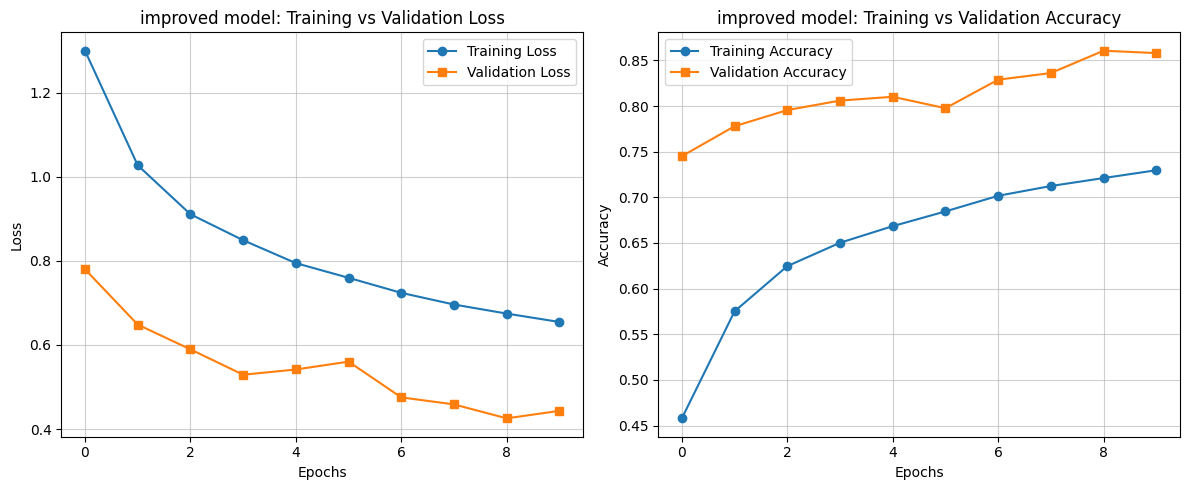

In [ ]:
evaluation_model(model_more_Dense_layers, history_more_Dense_layers, title='improved model', function_to_run='plot_training_curves')

### 3.4.2. Compute & Plot ROC Curve with AUC Score

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


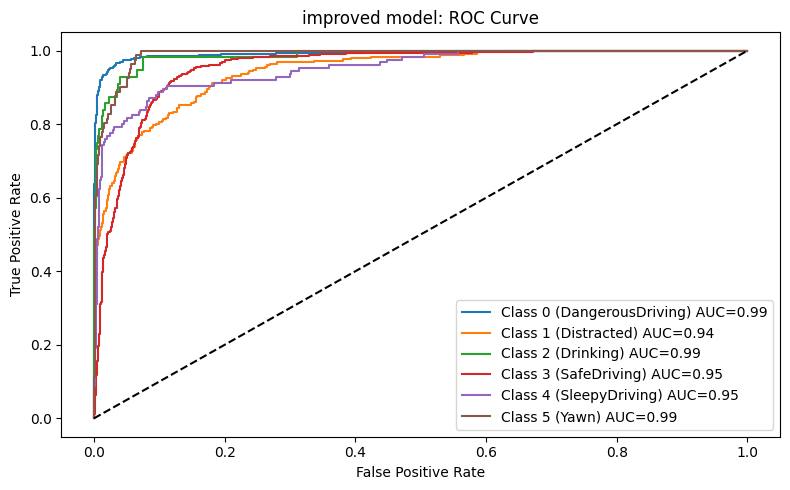

In [ ]:
evaluation_model(model_more_Dense_layers, history_more_Dense_layers, title='improved model', function_to_run='plot_roc_curve')

### 3.4.3. Compute & Plot Confusion Matrix

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


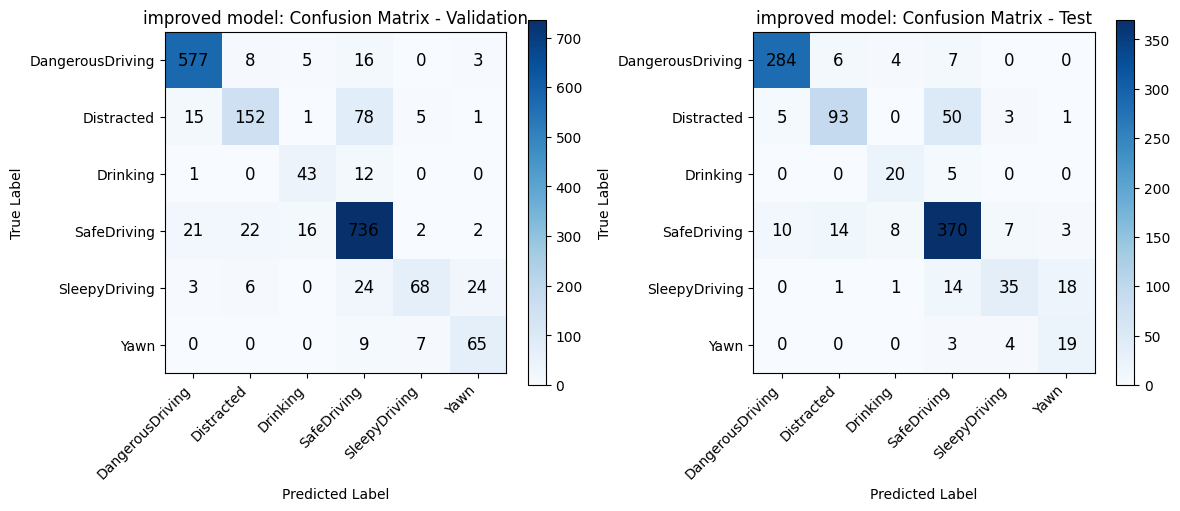

In [ ]:
evaluation_model(model_more_Dense_layers, history_more_Dense_layers, title='improved model', function_to_run='plot_confusion_matrix')

### 3.4.4. Plot Classification Metrics


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


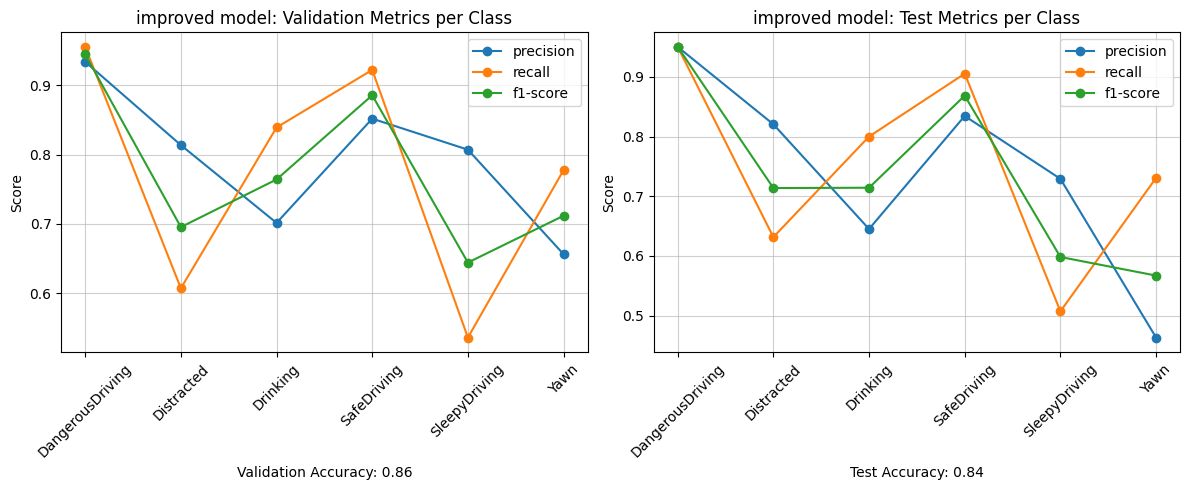

In [ ]:
evaluation_model(model_more_Dense_layers, history_more_Dense_layers, title='improved model', function_to_run='plot_classification_metrics')

### 3.4.5. Compute Performance Metrics (Accuracy, Precision, Recall, F1-Score)

In [ ]:
evaluation_model(model_more_Dense_layers, history_more_Dense_layers, title='improved model', function_to_run='classification_report_summary')


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

improved model - Classification Report:

Validation Performance Metrics:
                   precision    recall  f1-score
DangerousDriving   0.945902  0.947455  0.946678
Distracted         0.783505  0.603175  0.681614
Drinking           0.721311  0.785714  0.752137
SafeDriving        0.849315  0.931164  0.888358
SleepyDriving      0.829268  0.544000  0.657005
Yawn               0.666667  0.814815  0.733333

Validation Accuracy: 0.8590010405827263

Test Performance Metrics:
                   precision    recall  f1-score
DangerousDriving   0.936455  0.930233  0.933333
Distracted         0.810811  0.592105  0.684411
Drinking           0.571429  0.800000  0.666667
SafeDriving        0.817778  0.893204  0.853828
SleepyDriving      0.782609  0.521739  0.626087
Yawn               0.500000  0.846154  0.628571

Test Accuracy: 0.8284263959390863


# 4. Model training

## 4.1. Implementing Transfer Learning

In [ ]:
# Load the pre-trained DenseNet121 model (without top layers)
base_transfer_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze all layers in the base model
for layer in base_transfer_model.layers:
    layer.trainable = False

# Define new classifier on top of ResNet50
transfer_model_densenet = Sequential([
    Lambda(lambda x: tf.image.grayscale_to_rgb(x)),                  # Convert grayscale to RGB inside the model
    base_transfer_model,
    Flatten(),
    Dense(512, kernel_regularizer=l2(0.0001), activation="relu"),    # L2 Regularization to improve generalization
    BatchNormalization(),                                            # BatchNormalization to stabilize learning
    Dropout(0.3),                                                    # Added dropout to prevent overfitting
    Dense(256, kernel_regularizer=l2(0.0001), activation="relu"),    # L2 Regularization to improve generalization
    BatchNormalization(),                                            # BatchNormalization to stabilize learning
    Dropout(0.2),                                                    # Added dropout to prevent overfitting
    Dense(128, kernel_regularizer=l2(0.0001), activation='relu'),    # L2 Regularization to improve generalization
    BatchNormalization(),                                            # BatchNormalization to stabilize learning
    Dropout(0.15),                                                   # Added dropout to prevent overfitting
    Dense(6, activation='softmax')                                   # 6 output classes
])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)

# Compile the model
transfer_model_densenet.compile(optimizer=Adam(learning_rate=0.0001),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

# Train the transfer learning model
history_densenet = transfer_model_densenet.fit(augmented_train_data,
                                               validation_data=val_data,
                                               epochs=10,
                                               batch_size=64,
                                               callbacks = [early_stopping])


Epoch 1/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 106s 85ms/step - accuracy: 0.3790 - loss: 1.8428 - val_accuracy: 0.6842 - val_loss: 0.9980
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 52s 55ms/step - accuracy: 0.5462 - loss: 1.2831 - val_accuracy: 0.7227 - val_loss: 0.8649
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 52s 55ms/step - accuracy: 0.5915 - loss: 1.1506 - val_accuracy: 0.7440 - val_loss: 0.8422
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 52s 56ms/step - accuracy: 0.6098 - loss: 1.0926 - val_accuracy: 0.7643 - val_loss: 0.7730
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 51s 54ms/step - accuracy: 0.6244 - loss: 1.0537 - val_accuracy: 0.7414 - val_loss: 0.7839
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 53s 57ms/step - accuracy: 0.6361 - loss: 1.0141 - val_accuracy: 0.7919 - val_loss: 0.7130
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 52s 56ms/step - accuracy: 0.6526 - loss: 0.9800 - val_accuracy: 0.7794 - val_loss: 0.7098
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 52s 56ms/step - accuracy: 0.6643 - loss: 0.9565 -

# 5. Model evaluation

## 5.1. Evaluating the Transfer Learning Model

### 5.1.1. Accuracy & Loss Curves

61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 236ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 282ms/step


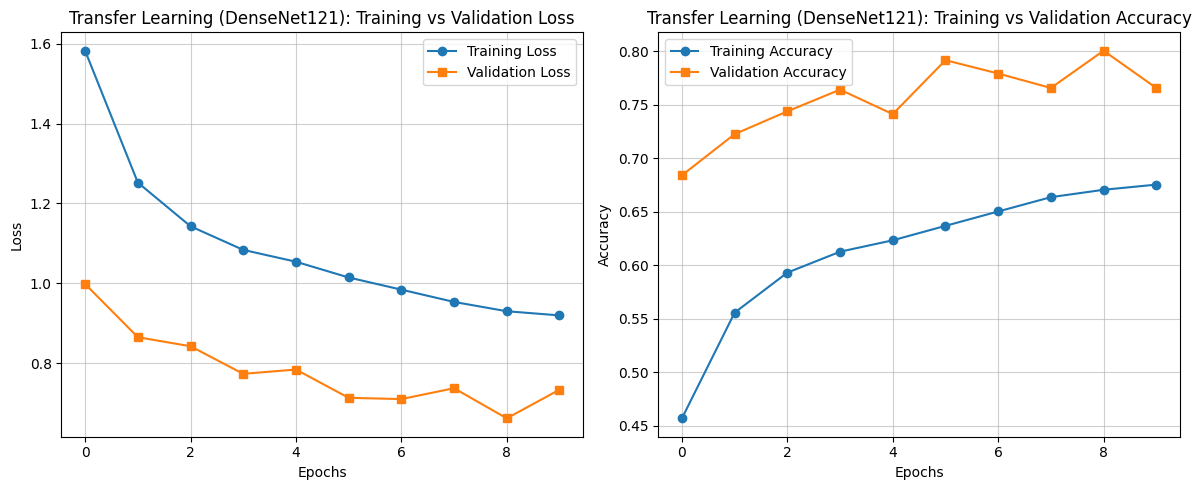

In [ ]:
evaluation_model(transfer_model_densenet, history_densenet, title="Transfer Learning (DenseNet121)", function_to_run="plot_training_curves")

### 5.1.2. ROC Curve & AUC Score

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


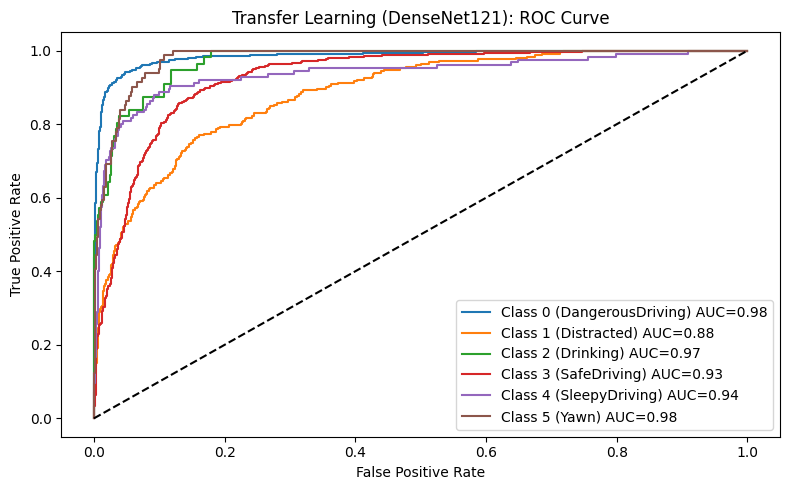

In [ ]:
evaluation_model(transfer_model_densenet, history_densenet, title="Transfer Learning (DenseNet121)", function_to_run="plot_roc_curve")

### 5.1.3. Confusion Matrix

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


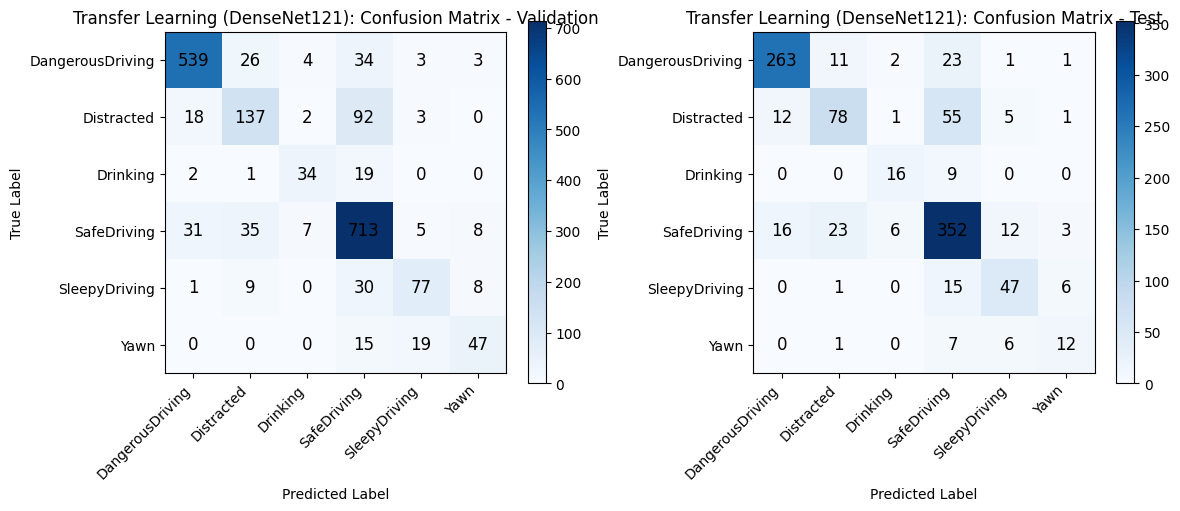

In [ ]:
evaluation_model(transfer_model_densenet, history_densenet, title="Transfer Learning (DenseNet121)", function_to_run="plot_confusion_matrix")

### 5.1.4. Classification Metrics

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step


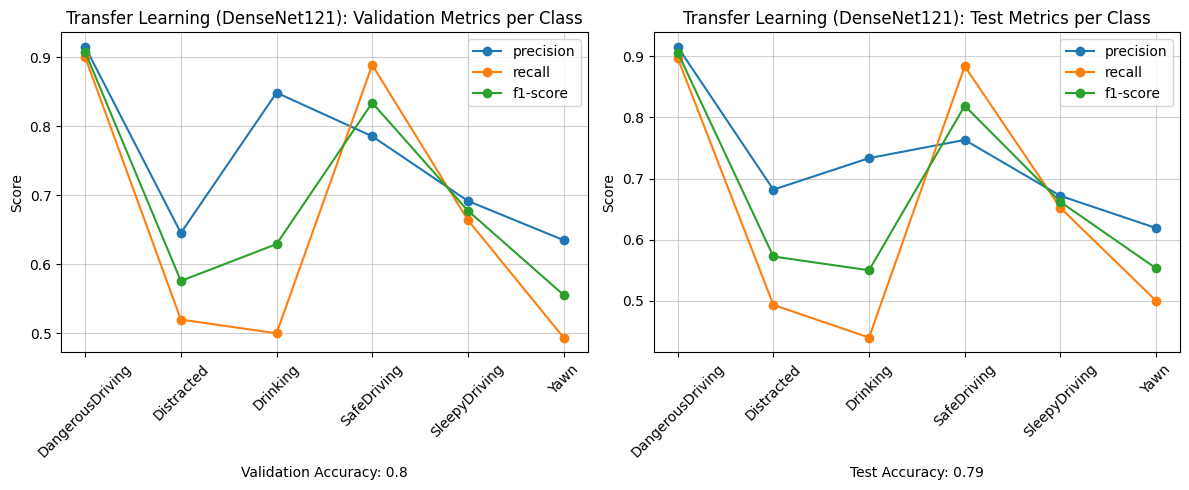

In [ ]:
evaluation_model(transfer_model_densenet, history_densenet, title="Transfer Learning (DenseNet121)", function_to_run="plot_classification_metrics")

### 5.1.5. Performance Metrics (Precision, Recall, F1-Score)

In [ ]:
evaluation_model(transfer_model_densenet, history_densenet, title="Transfer Learning (DenseNet121)", function_to_run="classification_report_summary")

61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step

Transfer Learning (DenseNet121) - Classification Report:

Validation Performance Metrics:
                   precision    recall  f1-score
DangerousDriving   0.912052  0.919540  0.915781
Distracted         0.635000  0.503968  0.561947
Drinking           0.861111  0.553571  0.673913
SafeDriving        0.788889  0.888611  0.835786
SleepyDriving      0.704348  0.648000  0.675000
Yawn               0.701754  0.493827  0.579710

Validation Accuracy: 0.8059313215400624

Test Performance Metrics:
                   precision    recall  f1-score
DangerousDriving   0.901316  0.910299  0.905785
Distracted         0.737864  0.500000  0.596078
Drinking           0.666667  0.560000  0.608696
SafeDriving        0.785558  0.871359  0.826237
SleepyDriving      0.724638  0.724638  0.724638
Yawn               0.516129  0.615385  0.561404

Test Accuracy: 0.8010152284263959
